<a href="https://colab.research.google.com/github/nawafalomari/advancedml/blob/main/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip -q install -U torch sentence-transformers scikit-learn matplotlib


# Save dataset from huggingface to DF

## Do not run this cell if you have the data

In [ ]:
!pip install -q "datasets<4.0.0"

import datasets
print("datasets version:", datasets.__version__)


^C
datasets version: 3.6.0


In [ ]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
BATCH_SIZE = 32
EPOCHS = 2
MAX_TRIPLETS_PER_ANCHOR = 4


In [ ]:
from datasets import load_dataset

# # titled_dataset = load_dataset(
# #     "saeedabc/wiki727k",
# #     num_proc=8,
# #     trust_remote_code=True,   # needed because this dataset uses a Python loading script
# # )

untitled_dataset = load_dataset(
    "saeedabc/wiki727k",
    drop_titles=True,         # custom config flag defined by the dataset script
    num_proc=8,
    trust_remote_code=True,
)

# print(titled_dataset)
print(untitled_dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wiki727k.py: 0.00B [00:00, ?B/s]

preprocess_util.py: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/582160 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/72354 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/73232 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'ids', 'sentences', 'labels'],
        num_rows: 582160
    })
    validation: Dataset({
        features: ['id', 'ids', 'sentences', 'labels'],
        num_rows: 72354
    })
    test: Dataset({
        features: ['id', 'ids', 'sentences', 'labels'],
        num_rows: 73232
    })
})


In [ ]:
df_train.head()

,id,ids,sentences,labels
0,808256,"[0_0, 0_1, 0_2, 0_3, 0_4, 0_5, 1_0, 1_1, 1_2, ...","[Urticating hairs or urticating bristles, i.e....","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,808818,"[0_0, 0_1, 0_2, 0_3, 0_4, 2_0, 2_1, 2_2, 2_3, ...","[According to legend, the health effects of te...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,808576,"[0_0, 0_1, 1_0, 1_1, 1_2, 1_3, 1_4, 1_5, 1_6, ...",[Clavering is a village and also a parish in n...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,808572,"[0_0, 0_1, 0_2, 1_0, 1_1, 1_2, 1_3, 1_4, 1_5, ...",[Uptown is one of Chicago’s 77 community areas...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,808049,"[0_0, 0_1, 0_2, 0_3, 1_0, 1_1, 1_2, 1_3, 1_4, ...","[George Frederic Watts, (London 23 February 18...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
import pandas as pd
import json

df_train = untitled_dataset['train'].select(range(5000)).to_pandas()
df_val = untitled_dataset['validation'].select(range(500)).to_pandas()
df_test = untitled_dataset['test'].select(range(500)).to_pandas()

import pandas as pd

def flatten_dataset(df):
    rows = []

    for _, row in df.iterrows():
        doc_id = row["id"]
        ids = row["ids"]
        sents = row["sentences"]

        for idx, (sid, sent) in enumerate(zip(ids, sents)):
            # sid format example: "3_12"
            paragraph_id, sent_id = sid.split("_")
            paragraph_id = int(paragraph_id)
            sent_id = int(sent_id)

            rows.append({
                "doc_id": doc_id,
                "paragraph_id": paragraph_id,
                "sent_id": sent_id,
                "global_index": idx,
                "sentence": sent,
            })

    return pd.DataFrame(rows)


In [ ]:
df_train = flatten_dataset(df_train)
df_val = flatten_dataset(df_val)
df_test = flatten_dataset(df_test)


In [ ]:
df_train.to_csv('train_5000.csv', index=False)
df_val.to_csv('val_500.csv', index=False)
df_test.to_csv('test_500.csv', index=False)

# Constents

In [ ]:
import torch.optim as opt
EPOCHS = 5
BATCH_SIZE = 32
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

OPTIMIZER_CLASS = opt.AdamW    # default optimizer
OPTIMIZER_PARAMS = {"lr": 2e-5}         # default learning rate
WARMUP_STEPS = 50                       # your setting
WEIGHT_DECAY = 0.01                     # AdamW default
SCHEDULER = "WarmupLinear"              # default scheduler


# Data preparation

In [ ]:
import pandas as pd
df_train  = pd.read_csv('train_5000.csv')
df_val  = pd.read_csv('val_500.csv')
df_test  = pd.read_csv('test_500.csv')



In [ ]:
df_train.head()

,doc_id,paragraph_id,sent_id,global_index,sentence
0,808256,0,0,0,"Urticating hairs or urticating bristles, i.e."
1,808256,0,1,1,"irritating hairs, are one of the primary defen..."
2,808256,0,2,2,"""Urtica"" is Latin for ""nettle"" (stinging nettl..."
3,808256,0,3,3,This term also refers to certain types of barb...
4,808256,0,4,4,Many tarantula species eject hairs from their ...


In [ ]:
def generate_pairs(df,far_k=3):
    pairs = []
    for doc_id, group in df.groupby("doc_id"):
        sents = group.sort_values("global_index")
        for i in range(len(sents) - 1):
            row1 = sents.iloc[i]
            row2 = sents.iloc[i+1]

            label = 1 if row1["paragraph_id"] == row2["paragraph_id"] else 0
            pairs.append([row1["sentence"], row2["sentence"], label])

            # We may need to consider far sentence from same paragraph as negative
            # This may help becuase we have too many postive examples here


            # if i+far_k < len(sents):
            #     far_neg = sents.iloc[i+far_k]
            #     pairs.append([row1["sentence"], far_neg["sentence"], 0])
    return pairs


In [ ]:
train_pairs = generate_pairs(df_train)
val_pairs = generate_pairs(df_val)
test_pairs = generate_pairs(df_test)


# Training

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

train_examples = [
    InputExample(texts=[s1, s2], label=float(lb))
    for (s1, s2, lb) in train_pairs
]

train_dataloader = DataLoader(train_examples, batch_size=32, shuffle=True)

model = SentenceTransformer("all-MiniLM-L6-v2")
train_loss = losses.ContrastiveLoss(model)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
import os
os.environ["WANDB_DISABLED"] = "true"

# ==== Prepare training data ====
train_examples = [
    InputExample(texts=[s1, s2], label=float(lb))
    for (s1, s2, lb) in train_pairs
]
train_dataloader = DataLoader(train_examples, batch_size=32, shuffle=True)

# ==== Prepare evaluation data ====
val_examples = [
    InputExample(texts=[s1, s2], label=float(lb))
    for (s1, s2, lb) in val_pairs
]

val_s1 = [ex.texts[0] for ex in val_examples]
val_s2 = [ex.texts[1] for ex in val_examples]
val_labels = [ex.label for ex in val_examples]

evaluator = EmbeddingSimilarityEvaluator(
    val_s1,
    val_s2,
    val_labels,
    name="chunking-eval"
)

# ==== Model + Loss ====
model = SentenceTransformer("all-MiniLM-L6-v2")
train_loss = losses.ContrastiveLoss(model)

# ==== Train ====
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,          # <-- ADD THIS
    evaluation_steps=100,         # evaluate every 100 steps
    epochs=EPOCHS,
    warmup_steps=WARMUP_STEPS,
    show_progress_bar=True
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Chunking-eval Pearson Cosine,Chunking-eval Spearman Cosine
100,No log,No log,0.062834,0.109103
200,No log,No log,0.083296,0.124136
300,No log,No log,0.107499,0.141308
400,No log,No log,0.133209,0.157826
500,0.022400,No log,0.158618,0.173051
600,0.022400,No log,0.185167,0.187423
700,0.022400,No log,0.200326,0.197293
800,0.022400,No log,0.218922,0.206750
900,0.022400,No log,0.240504,0.216909
1000,0.010300,No log,0.247925,0.220522


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2650722746.py", line 36, in <cell line: 0>
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/sentence_transformers/fit_mixin.py", line 408, in fit
    trainer.train(resume_from_checkpoint=resume_from_checkpoint)
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 2325, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 2756, in _inner_training_loop
    self._maybe_log_save_evaluate(
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 3221, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib

TypeError: object of type 'NoneType' has no len()

# Evaluation

In [ ]:
# ============================================================
#  Convert DF → {doc_id: {sentences, boundaries}}
# ============================================================
def df_to_eval_docs(df):
    """
    Convert your dataframe into a dict:
    {
      doc_id: {
         'sentences': [...],
         'boundaries': [0/1,...]
      }
    }
    """
    docs = {}

    for doc_id, group in df.groupby("doc_id"):
        g = group.sort_values("global_index")

        sentences = g["sentence"].tolist()
        paragraph_ids = g["paragraph_id"].tolist()

        if len(sentences) < 2:
            continue

        # gold boundaries (1 when paragraph changes)
        boundaries = []
        for i in range(len(paragraph_ids) - 1):
            if paragraph_ids[i] != paragraph_ids[i+1]:
                boundaries.append(1)
            else:
                boundaries.append(0)
        boundaries.append(1)  # last sentence closes a chunk

        docs[doc_id] = {"sentences": sentences, "boundaries": boundaries}

    return docs


# ============================================================
# ChromaDB boundary metrics: IoU, Recall, Precision
# ============================================================
def chroma_metrics(gold, pred):
    gold = np.asarray(gold)
    pred = np.asarray(pred)

    intersection = np.sum((gold == 1) & (pred == 1))
    union = np.sum((gold == 1) | (pred == 1))

    iou = intersection / union if union > 0 else 0.0
    recall = intersection / np.sum(gold == 1) if np.sum(gold == 1) > 0 else 0.0
    precision = intersection / np.sum(pred == 1) if np.sum(pred == 1) > 0 else 0.0

    return {
        "iou": float(iou),
        "recall": float(recall),
        "precision": float(precision),
        "intersection": int(intersection),
        "union": int(union),
        "gold_boundaries": int(np.sum(gold == 1)),
        "pred_boundaries": int(np.sum(pred == 1)),
    }


# ============================================================
# Predict boundaries from cosine similarity
# ============================================================
def predict_boundaries_from_embeddings(embeddings, method="median", value=None):
    """
    embeddings: np array (N, D)

    method options:
        - "median"
        - "mean"
        - "p10", "p20", "p30", "p40", ....
        - "fixed"  (requires value=some_number)

    Returns:
        pred_boundaries, threshold_value
    """

    emb = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
    sims = (emb[:-1] * emb[1:]).sum(axis=1)  # cosine similarities

    # Adaptive thresholds
    if method == "median":
        threshold = np.median(sims)

    elif method == "mean":
        threshold = float(np.mean(sims) - np.std(sims))  # mean - std

    elif method.startswith("p"):
        pct = int(method[1:])   # get number after p
        threshold = np.percentile(sims, pct)

    # Fixed manual threshold
    elif method == "fixed":
        if value is None:
            raise ValueError("For method='fixed', you must supply value=")
        threshold = float(value)

    else:
        raise ValueError(f"Unknown threshold method: {method}")

    # Predict: similarity < threshold => boundary
    pred_pairs = (sims < threshold).astype(int)

    pred_boundaries = list(pred_pairs) + [1] # +1 last sentence
    return pred_boundaries, threshold


# ============================================================
#     Evaluate all docs for a given embedding function
# ============================================================
def evaluate_docs(docs, embed_fn, name="model", threshold_method="median"):
    print(f"\n========== Evaluating: {name} ==========")

    metrics_per_doc = []
    ious, recalls, precisions = [], [], []

    for doc_id, doc in docs.items():
        sentences = doc["sentences"]
        gold = doc["boundaries"]

        # --- embed ---
        embeddings = embed_fn(sentences)

        # --- predict boundaries ---
        pred_boundaries, threshold = predict_boundaries_from_embeddings(
            embeddings, method=threshold_method
        )

        # --- compute metrics ---
        m = chroma_metrics(gold, pred_boundaries)

        metrics_per_doc.append((doc_id, m))
        ious.append(m["iou"])
        recalls.append(m["recall"])
        precisions.append(m["precision"])

        print(f"Doc {doc_id}: IoU={m['iou']:.3f}, Recall={m['recall']:.3f}, Precision={m['precision']:.3f}")

    summary = {
        "iou_mean": float(np.mean(ious)),
        "recall_mean": float(np.mean(recalls)),
        "precision_mean": float(np.mean(precisions)),
        "docs_evaluated": len(metrics_per_doc),
    }

    print("\n------ Summary ------")
    print(summary)
    return metrics_per_doc, summary


# ============================================================
# Embedding functions (before + after training)
# ============================================================
# before_model = SentenceTransformer("all-MiniLM-L6-v2")
# def embed_before(sent_list):
#     return before_model.encode(sent_list, convert_to_numpy=True, batch_size=32, show_progress_bar=False)

def embed_after(sent_list):
    return model.encode(sent_list, convert_to_numpy=True, batch_size=32, show_progress_bar=False)


def try_multiple_thresholds(docs, embed_fn, methods):
    all_summaries = {}
    for method in methods:
        print(f"\n========== Threshold: {method} ==========")
        _, summary = evaluate_docs(docs, embed_fn, threshold_method=method, name=method)
        all_summaries[method] = summary
    return all_summaries




df = pd.read_csv("/content/test_500.csv")
docs = df_to_eval_docs(df)

print("Loaded docs:", len(docs))

# BEFORE (baseline MiniLM)
methods = ["median", "p20", "p30", "p40", "mean"]
summaries = try_multiple_thresholds(docs, embed_after, methods)
print("\n=== THRESHOLD COMPARISON ===")
for m, s in summaries.items():
    print(m, "→ IoU:", s["iou_mean"], " Recall:", s["recall_mean"] , " Precision:", s["precision_mean"] ,"len:" , s["docs_evaluated"] )


# AFTER
# after_results, after_summary = evaluate_docs(docs, embed_after, name="After Training")

print("\nDone.")


Loaded docs: 500

========== Threshold: median ==========

========== Evaluating: median ==========
Doc 800118: IoU=0.250, Recall=0.667, Precision=0.286
Doc 800269: IoU=0.267, Recall=0.800, Precision=0.286
Doc 800373: IoU=0.161, Recall=0.818, Precision=0.167
Doc 800391: IoU=0.211, Recall=0.800, Precision=0.222
Doc 800801: IoU=0.176, Recall=1.000, Precision=0.176
Doc 801152: IoU=0.240, Recall=0.857, Precision=0.250
Doc 801264: IoU=0.231, Recall=1.000, Precision=0.231
Doc 801463: IoU=0.308, Recall=0.800, Precision=0.333
Doc 801573: IoU=0.130, Recall=1.000, Precision=0.130
Doc 803044: IoU=0.159, Recall=1.000, Precision=0.159
Doc 803145: IoU=0.194, Recall=1.000, Precision=0.194
Doc 803218: IoU=0.333, Recall=1.000, Precision=0.333
Doc 803239: IoU=0.214, Recall=1.000, Precision=0.214
Doc 803277: IoU=0.167, Recall=0.750, Precision=0.176
Doc 803419: IoU=0.400, Recall=1.000, Precision=0.400
Doc 803444: IoU=0.111, Recall=0.250, Precision=0.167
Doc 803627: IoU=0.107, Recall=0.750, Precision=0.111

In [ ]:
print("\n=== THRESHOLD COMPARISON ===")
for m, s in summaries.items():
    print(m, "→ IoU:", s["iou_mean"], " Recall:", s["recall_mean"] , " Precision:", s["precision_mean"] ,"len:" , s["docs_evaluated"] )



=== THRESHOLD COMPARISON ===
median → IoU: 0.21909303039941933  Recall: 0.8476744083367613  Precision: 0.22870254811729546 len: 500
p20 → IoU: 0.29403174047932973  Recall: 0.6101405748499867  Precision: 0.3573917463618969 len: 500
p30 → IoU: 0.27143818703030603  Recall: 0.723264329755212  Precision: 0.3019071253001814 len: 500
p40 → IoU: 0.24315805109389077  Recall: 0.791598747918748  Precision: 0.2594763299127142 len: 500
mean → IoU: 0.31881785613521524  Recall: 0.5260147108120637  Precision: 0.4465430878604062 len: 500


In [ ]:
model.save("/content/saved_model")

In [ ]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/README.md (deflated 67%)
  adding: content/saved_model/tokenizer.json (deflated 71%)
  adding: content/saved_model/tokenizer_config.json (deflated 73%)
  adding: content/saved_model/2_Normalize/ (stored 0%)
  adding: content/saved_model/vocab.txt (deflated 53%)
  adding: content/saved_model/sentence_bert_config.json (deflated 9%)
  adding: content/saved_model/config_sentence_transformers.json (deflated 40%)
  adding: content/saved_model/1_Pooling/ (stored 0%)
  adding: content/saved_model/1_Pooling/config.json (deflated 59%)
  adding: content/saved_model/special_tokens_map.json (deflated 80%)
  adding: content/saved_model/config.json (deflated 47%)
  adding: content/saved_model/modules.json (deflated 62%)
  adding: content/saved_model/model.safetensors (deflated 8%)




---



---



# NawaF


In [ ]:
# If you're in Colab or a machine with internet, uncomment to install.
%pip -q install -U torch sentence-transformers scikit-learn matplotlib


In [ ]:
!git clone https://github.com/nawafalomari/advancedml.git

Cloning into 'advancedml'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), 10.58 MiB | 15.91 MiB/s, done.


In [ ]:
%cd advancedml

/content/advancedml


In [ ]:
import os, random, math, itertools
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

# from sentence_transformers import SentenceTransformer, InputExample, losses, util
# from torch.utils.data import DataLoader

# import torch
# SEED = 42
# random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(SEED)


In [ ]:
# === Config ===
DATASET_CSV = r"triplet_samples (2).csv"  # update path if needed
COL_A = "sentence2"
COL_B = "sentence1"
LABEL_COL = "label"  # 1=similar, 0=dissimilar

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
BATCH_SIZE = 32
EPOCHS = 2
MARGIN = 0.2
MAX_TRIPLETS_PER_ANCHOR = 4
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [ ]:
df = pd.read_csv(DATASET_CSV)
assert all(c in df.columns for c in [COL_A, COL_B, LABEL_COL]), f"Expected columns {[COL_A, COL_B, LABEL_COL]} not found. Found: {list(df.columns)}"
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)
print(df.head())
print("Counts:", df[LABEL_COL].value_counts().to_dict())


                                           sentence1  \
0               Their Nasdaq ticker symbol was NTIQ.   
1                    There is no chain of narration.   
2  The equivalent Japanese term for "dojang" is "...   
3           Salido lost the bout via split decision.   
4  An ABC News poll found that the majority (58%)...   

                                           sentence2  label  
0  Certain intellectual property assets are plann...      0  
1  It relates to the autocorrelations of the time...      0  
2  Unlike other paints that create special effect...      0  
3  The figure shows a set "X" of 16 points in the...      0  
4  The poll found opposition to same-sex marriage...      1  
Counts: {0: 50000, 1: 50000}


In [ ]:
df.head(30)

,sentence1,sentence2,label
0,Their Nasdaq ticker symbol was NTIQ.,Certain intellectual property assets are plann...,0
1,There is no chain of narration.,It relates to the autocorrelations of the time...,0
2,"The equivalent Japanese term for ""dojang"" is ""...",Unlike other paints that create special effect...,0
3,Salido lost the bout via split decision.,"The figure shows a set ""X"" of 16 points in the...",0
4,An ABC News poll found that the majority (58%)...,The poll found opposition to same-sex marriage...,1
5,The rules of the main game were exactly the sa...,The Soviet government valued Kursk for rich de...,0
6,"""Averbode's Weekblad"" disappeared in 1964 with...",On the occasion of Govind Pai's 125th birthday...,0
7,implementation of merit-based policies and pro...,"fiscal year from the committee chairpersons, t...",1
8,The first signs of Christian Mysticism in Afri...,Mahfouz is able to capture a lifetime's worth ...,0
9,The third-placed candidate became the leader o...,or upon order of the House;,1


In [ ]:
# sen = df.iloc[4]['sentence1']
# df[df['sentence1']==sen]

In [ ]:
from collections import defaultdict

def build_triplets_from_pairs(df, col_a, col_b, label_col, max_triplets_per_anchor=None, include_reverse=True):
    """Construct (anchor, positive, negative) triplets from pairwise similarity labels."""
    da = df[col_a].astype(str).tolist()
    db = df[col_b].astype(str).tolist()
    dl = df[label_col].astype(int).tolist()

    pos = defaultdict(set)
    neg = defaultdict(set)

    for a, b, y in zip(da, db, dl):
        if y == 1:
            pos[a].add(b)
            if include_reverse:
                pos[b].add(a)
        else:
            neg[a].add(b)
            if include_reverse:
                neg[b].add(a)

    triplets = []
    for anchor, pos_set in pos.items():
        neg_set = neg.get(anchor, set())
        if not pos_set or not neg_set:
            continue

        pos_list = list(pos_set)
        neg_list = list(neg_set)
        random.shuffle(pos_list); random.shuffle(neg_list)

        if max_triplets_per_anchor:
            pos_list = pos_list[:max_triplets_per_anchor]
            neg_list = neg_list[:max_triplets_per_anchor]

        for p in pos_list:
            for n in neg_list:
                triplets.append((anchor, p, n))

    return triplets

triplets = build_triplets_from_pairs(df, COL_A, COL_B, LABEL_COL, max_triplets_per_anchor=MAX_TRIPLETS_PER_ANCHOR, include_reverse=True)
print(f"Built {len(triplets):,} triplets from {len(df):,} pairs.")
print('Example:', triplets[0] if len(triplets)>0 else None)


Built 9,558 triplets from 100,000 pairs.
Example: ('or upon order of the House;', 'in accordance with Civil Service rules: Provided, That the suspension or dismissal of', 'Although the Chilean model has been recommended for adoption in other Latin American countries, none has yet accepted it in its original form.')


In [ ]:
train_examples = [InputExample(texts=[a, p, n]) for (a,p,n) in triplets]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)

model = SentenceTransformer(MODEL_NAME)
train_loss = losses.TripletLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE)

print(f"Model: {MODEL_NAME}")
print(f"Triplets: {len(train_examples):,} | Batch size: {BATCH_SIZE} | Epochs: {EPOCHS} | Margin: {MARGIN}")


Model: sentence-transformers/all-MiniLM-L6-v2
Triplets: 9,558 | Batch size: 32 | Epochs: 2 | Margin: 0.2


In [ ]:
from sklearn.metrics import roc_auc_score
from sentence_transformers import util

@torch.no_grad()
def quick_eval(model, pairs_df, col_a, col_b, label_col, sample_size=2000):
    pairs = pairs_df.sample(n=min(sample_size, len(pairs_df)), random_state=SEED)
    a_emb = model.encode(pairs[col_a].astype(str).tolist(), convert_to_tensor=True, show_progress_bar=False, normalize_embeddings=True)
    b_emb = model.encode(pairs[col_b].astype(str).tolist(), convert_to_tensor=True, show_progress_bar=False, normalize_embeddings=True)
    sims = util.cos_sim(a_emb, b_emb).diagonal().cpu().numpy()
    y = pairs[label_col].to_numpy().astype(int)
    auc = roc_auc_score(y, sims)
    return auc, sims, y

print("Running quick pre-train AUC...")
pre_auc, pre_sims, pre_y = quick_eval(model, df, COL_A, COL_B, LABEL_COL, sample_size=2000)
print(f"Pre-train ROC-AUC (pairwise similarity): {pre_auc:.4f}")


Running quick pre-train AUC...
Pre-train ROC-AUC (pairwise similarity): 0.9308


In [ ]:
import os
# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"
warmup_steps = int(len(train_dataloader) * EPOCHS * 0.1)
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=10,
    warmup_steps=warmup_steps,
    output_path=OUTPUT_DIR,
    show_progress_bar=True
)
print("Training complete. Model saved to:", OUTPUT_DIR)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,3.160500
1000,3.157400
1500,3.147700
2000,3.142700
2500,3.141100


Post-train ROC-AUC (pairwise similarity): 0.9184


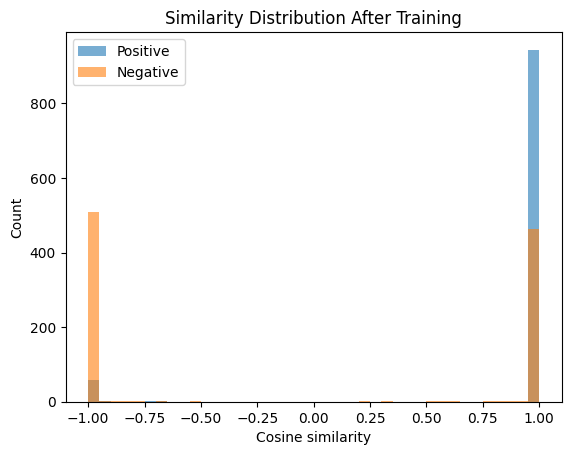

In [ ]:
fine_tuned = SentenceTransformer(OUTPUT_DIR)
post_auc, post_sims, post_y = quick_eval(fine_tuned, df, COL_A, COL_B, LABEL_COL, sample_size=2000)
print(f"Post-train ROC-AUC (pairwise similarity): {post_auc:.4f}")

plt.figure()
plt.hist(post_sims[post_y==1], bins=40, alpha=0.6, label="Positive")
plt.hist(post_sims[post_y==0], bins=40, alpha=0.6, label="Negative")
plt.title("Similarity Distribution After Training")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.legend()
plt.show()


In [ ]:
examples = [
    (df.iloc[0][COL_A], df.iloc[0][COL_B]),
    (df.iloc[1][COL_A], df.iloc[1][COL_B]),
]
emb_a = fine_tuned.encode([ex[0] for ex in examples], convert_to_tensor=True, show_progress_bar=False, normalize_embeddings=True)
emb_b = fine_tuned.encode([ex[1] for ex in examples], convert_to_tensor=True, show_progress_bar=False, normalize_embeddings=True)
sims = util.cos_sim(emb_a, emb_b).diagonal().cpu().numpy()
for (ta, tb), s in zip(examples, sims):
    print(f"Sim = {s:.3f}\nA: {str(ta)[:120]}\nB: {str(tb)[:120]}\n---")


Sim = 0.574
A: Certain intellectual property assets are planned to be sold to CPTN Holdings, a consortium of companies led by Microsoft
B: Their Nasdaq ticker symbol was NTIQ.
---
Sim = 0.448
A: It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of 
B: There is no chain of narration.
---


In [ ]:
all_texts = pd.unique(pd.concat([df[COL_A].astype(str), df[COL_B].astype(str)], ignore_index=True)).tolist()
print(f"Encoding {len(all_texts):,} unique texts...")
emb = fine_tuned.encode(all_texts, convert_to_tensor=False, show_progress_bar=True, normalize_embeddings=True)
emb = np.asarray(emb, dtype=np.float32)
np.save(os.path.join(OUTPUT_DIR, "corpus_embeddings.npy"), emb)
pd.Series(all_texts).to_csv(os.path.join(OUTPUT_DIR, "corpus_texts.csv"), index=False)
print("Saved corpus embeddings and texts to:", OUTPUT_DIR)
